In [1]:
import pandas as pd
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 200)

import numpy as np

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedKFold

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from optuna.samplers import TPESampler

In [2]:
ordinal = pd.read_csv('../../../Data/BaseOrdinal.csv')
ordinal.shape

(2580, 83)

In [3]:
ordinal = ordinal.drop(['Unnamed: 0', 'PID', 'Unnamed: 0.1'], axis=1)
ordinal.shape

(2580, 80)

In [4]:
#ordinal.head(3)

In [5]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
    }
    # Conditional Hyper-Parameters
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    reg = CatBoostRegressor(**param, cat_features=categorical_features_indices)
    reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100)
    y_pred = reg.predict(X_test)
    score = r2_score(y_test, y_pred)
    return score

In [10]:
X = ordinal.drop(['SalePrice'], axis=1)
y = ordinal['SalePrice']

categorical_features_indices = np.where(X.dtypes != np.float)[0]

study = optuna.create_study(sampler=TPESampler(), direction="maximize")
study.optimize(objective, n_trials=100, timeout=600) # Run for 10 minutes
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-05-19 04:45:32,551] A new study created in memory with name: no-name-d32a47ba-ef75-4b9a-8d3d-8f0dcfdab750
[I 2022-05-19 04:45:35,771] Trial 0 finished with value: 0.9145966756568817 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.03126128881300504, 'l2_leaf_reg': 0.7932093477389193, 'colsample_bylevel': 0.09234292219665938, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 18, 'one_hot_max_size': 5, 'subsample': 0.8895765061700885}. Best is trial 0 with value: 0.9145966756568817.
[I 2022-05-19 04:45:36,735] Trial 1 finished with value: 0.8779987339866764 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.054614532093053725, 'l2_leaf_reg': 0.011379748151209242, 'colsample_bylevel': 0.0489561689737194, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 20, 'one_hot_max_size': 13, 'bagging_temperature': 0.051098257571943195}. Best is trial 0 with value: 0.9145966756568817.
[I 2022

[I 2022-05-19 04:46:12,609] Trial 19 finished with value: 0.3813965434890324 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.00042812177158285555, 'l2_leaf_reg': 0.4476898280463368, 'colsample_bylevel': 0.05726502582690372, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 12, 'one_hot_max_size': 5}. Best is trial 13 with value: 0.9162416150574744.
[I 2022-05-19 04:46:13,023] Trial 20 finished with value: 0.8203182894207948 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.9840670551097953, 'l2_leaf_reg': 0.8489502952309688, 'colsample_bylevel': 0.0845355299288916, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 16, 'one_hot_max_size': 12, 'subsample': 0.49097298358711194}. Best is trial 13 with value: 0.9162416150574744.
[I 2022-05-19 04:46:14,297] Trial 21 finished with value: 0.9093860966809626 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.04578929790663431, 'l2_leaf_

[I 2022-05-19 04:46:31,660] Trial 38 finished with value: 0.8378869064252266 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.22695341050943152, 'l2_leaf_reg': 0.024552818786506593, 'colsample_bylevel': 0.07875454199490464, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'one_hot_max_size': 12, 'subsample': 0.5961222614539541}. Best is trial 25 with value: 0.9175337821640855.
[I 2022-05-19 04:46:32,840] Trial 39 finished with value: 0.7609673018104838 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.006598823990994747, 'l2_leaf_reg': 0.08014932583409815, 'colsample_bylevel': 0.09464653471670936, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 17, 'one_hot_max_size': 17, 'bagging_temperature': 6.810850392313772}. Best is trial 25 with value: 0.9175337821640855.
[I 2022-05-19 04:46:33,414] Trial 40 finished with value: 0.5288408584324572 and parameters: {'loss_function': 'RMSE', 

[I 2022-05-19 04:47:17,697] Trial 57 finished with value: 0.8363022117040381 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.6844256739257775, 'l2_leaf_reg': 0.873634327132598, 'colsample_bylevel': 0.06666728129565802, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 15, 'one_hot_max_size': 2, 'subsample': 0.8005360167982967}. Best is trial 52 with value: 0.9190488800307046.
[I 2022-05-19 04:47:20,700] Trial 58 finished with value: 0.9034788251595698 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.20888777442964382, 'l2_leaf_reg': 0.44987113273381796, 'colsample_bylevel': 0.08254240118995972, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 18, 'one_hot_max_size': 8, 'subsample': 0.22897175057252378}. Best is trial 52 with value: 0.9190488800307046.
[I 2022-05-19 04:47:24,781] Trial 59 finished with value: 0.8866667411191523 and parameters: {'loss_function': 'MAE', 'learning_ra

[I 2022-05-19 04:47:55,900] Trial 76 finished with value: 0.8580268970390967 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.015831472500676253, 'l2_leaf_reg': 0.03332598706714902, 'colsample_bylevel': 0.06282579490674214, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 18, 'one_hot_max_size': 19, 'subsample': 0.7332254857070561}. Best is trial 52 with value: 0.9190488800307046.
[I 2022-05-19 04:47:56,519] Trial 77 finished with value: 0.9037768764104257 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.05581360401635142, 'l2_leaf_reg': 0.08332143159821427, 'colsample_bylevel': 0.0690901313799885, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 19, 'one_hot_max_size': 17}. Best is trial 52 with value: 0.9190488800307046.
[I 2022-05-19 04:47:57,036] Trial 78 finished with value: 0.8545221821931801 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.026901923670562655, 'l2_leaf_r

[I 2022-05-19 04:48:16,614] Trial 95 finished with value: 0.020333007077385723 and parameters: {'loss_function': 'RMSE', 'learning_rate': 2.2264770050817168e-05, 'l2_leaf_reg': 0.04108508404451368, 'colsample_bylevel': 0.08609988570219494, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 8, 'one_hot_max_size': 17, 'bagging_temperature': 5.143127635732114}. Best is trial 92 with value: 0.9198679216185126.
[I 2022-05-19 04:48:17,868] Trial 96 finished with value: 0.9171314226457769 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.16962762942779927, 'l2_leaf_reg': 0.017360413334777395, 'colsample_bylevel': 0.07912793295589213, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 3, 'one_hot_max_size': 3, 'subsample': 0.6689779515066692}. Best is trial 92 with value: 0.9198679216185126.
[I 2022-05-19 04:48:19,911] Trial 97 finished with value: 0.8844763596426547 and parameters: {'loss_function': 'RMS

Number of completed trials: 100
Best trial:
	Best Score: 0.9198679216185126
	Best Params: 
    loss_function: RMSE
    learning_rate: 0.05146920834345779
    l2_leaf_reg: 0.03110054557536701
    colsample_bylevel: 0.07844470919193748
    depth: 4
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    min_data_in_leaf: 15
    one_hot_max_size: 17
    subsample: 0.7596370741766397


In [37]:
study.best_params

{'loss_function': 'RMSE',
 'learning_rate': 0.05146920834345779,
 'l2_leaf_reg': 0.03110054557536701,
 'colsample_bylevel': 0.07844470919193748,
 'depth': 4,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bernoulli',
 'min_data_in_leaf': 15,
 'one_hot_max_size': 17,
 'subsample': 0.7596370741766397}

In [11]:
optuna.visualization.plot_param_importances(study)

In [12]:
optuna.visualization.plot_optimization_history(study)

In [13]:
optuna.visualization.plot_slice(study, params=['depth', 'learning_rate', 'bootstrap_type'])

In [38]:
CB = CatBoostRegressor(**study.best_params, verbose=0)

In [39]:
scoring = {'r2': 'r2',
           'neg_mae': 'neg_mean_absolute_error'
          }

In [40]:
# Use cross-validation to evaluate model performance

def evaluate_model(model, X, y):
    
    # define the evaluation procedure
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    # evaluate the model and collect the results
    scores = cross_validate(model, X, y, scoring=scoring, 
                                  cv=cv, n_jobs=-1) 
    
    df = pd.DataFrame(scores)
    
    return df

In [42]:
evaluate_model(CB, X, y).describe()

,fit_time,score_time,test_r2,test_neg_mae
count,15.000000,15.000000,15.000000,15.000000
mean,1.473067,0.005859,0.917918,-13099.902609
std,0.083790,0.002311,0.034540,876.125876
min,1.335535,0.003380,0.823670,-14958.890844
25%,1.429531,0.004161,0.920659,-13551.430586
50%,1.450173,0.005084,0.931138,-13253.874796
75%,1.497899,0.007006,0.935925,-12611.357974
max,1.647054,0.012165,0.947273,-11604.200231


In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25)
    
CB.fit(X_train, Y_train, verbose=False)
y_pred = CB.predict(X_test)

CB_Score = r2_score(Y_test, y_pred)
CB_Score
    

0.928840546114355

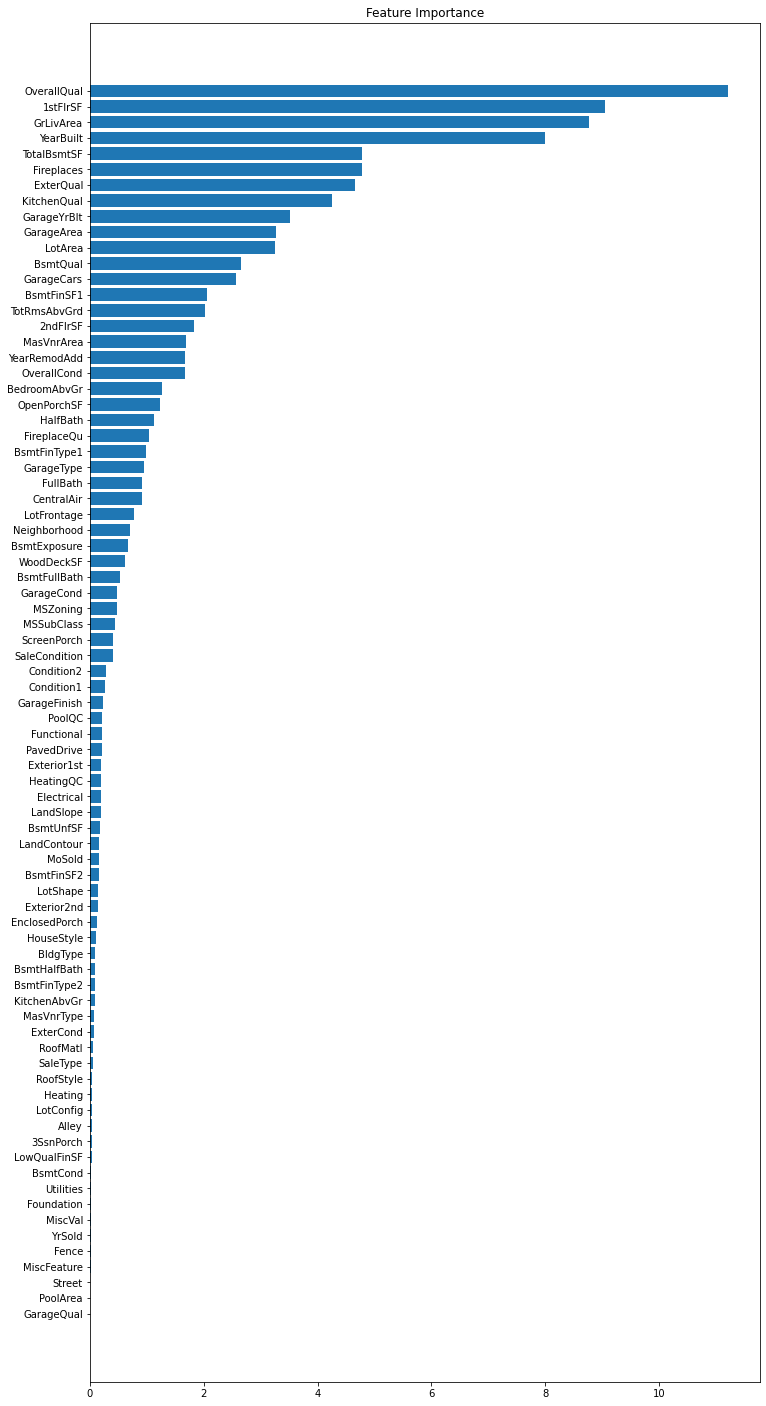

In [46]:
feature_importance = CB.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 25))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance');
